# A physics-aware DL model for hydrologic modeling

Recently, Jiang et al. (2020) developed a general approach to educating AI geoscientific knowledge by wrapping physical approaches, speciﬁcally dynamic geoscientific models, as special neural layers into a deep learning (DL) architecture. In that study, rainfall-runoff modeling in 569 catchments across the conterminous United States (CONUS) is used here as an illustrative case.

The key step of implementing the physics-aware DL model is the development of the P-RNN layer, by which physical knowledge can be seamlessly implanted into a DL architecture. This simlple example will show how to use the developed P-RNN layer for rainfall-runoff modelling and show how to replicate SI Figure S5 of the paper in which one model is trained per basin. 

Note: This is not an exact replication of the model setup, but can be easily extended to the settings of the paper. 

For running this notebook, no GPU is required, and everything should run fine on a standard CPU.

If you use this repository in your work, please cite:

Jiang, S., Zheng, Y., and Solomatine, D. (2020) Improving AI system awareness of geoscience knowledge: Symbiotic integration of physical approaches and deep learning, *Geophysical Research Letters*, 47. https://doi.org/10.1029/2020GL088229

Date: 10.06.2020

Created by: Shijie Jiang (jiangsj(at)mail.sustech.edu.cn)

In [1]:
## Import dependent libraries
import os
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from keras.models import Model
from keras.layers import Input, Concatenate
from keras import optimizers, callbacks
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

## Import libraries developed by this study
from libs.hydrolayer import PRNNLayer, ConvLayer, ScaleLayer
from libs.hydrodata import DataforIndividual
from libs import hydroutils

## Ignore all the warnings
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['KMP_WARNINGS'] = '0'

Using TensorFlow backend.


**Please change the following working path to your owns.**

In [2]:
working_path = '/home/shijie/physics-AI'

## 1. Prepare data

### 1.1. Load data

Here we use a custom class `DataforIndividual` imported from `libs.hydrodata` for preprocessing the downloaded CAMELS data set.

The data has 6 dims, including 5 inputs (daily precipitation (***prcp***), daily mean temperature (***tmean***), day length (***dayl***), as well as average solar radiation (***srad***) and vapor pressure (***vp***)) and 1 output (runoff (***q***)).

Data in basin #01013500 at huc #01 has been successfully loaded.


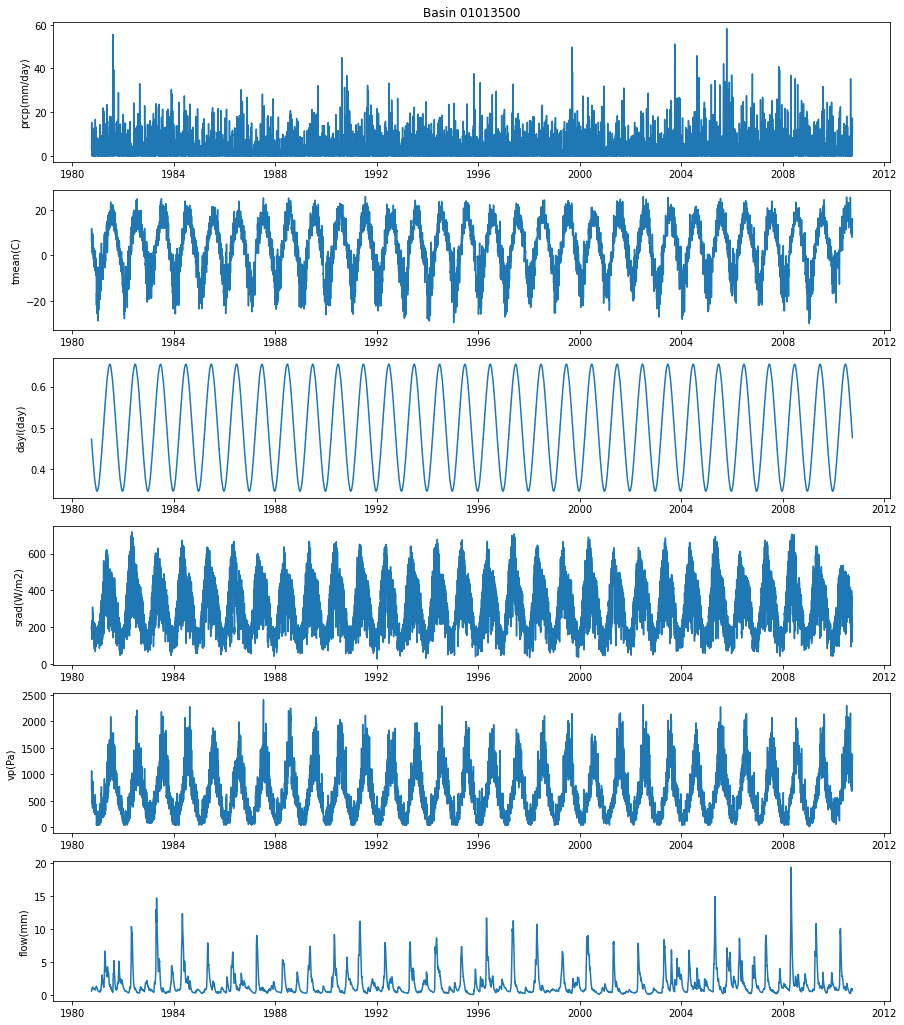

In [3]:
####################
#   Basin set up   #
####################
basin_id = '01013500' # The basin_id can be changed to any 8-digit basin id contained in the basin_list.txt

hydrodata = DataforIndividual(working_path, basin_id).load_data()

# Plot the data loaded for overview
fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(nrows=6, ncols=1, sharex='row', figsize=(15, 18))

ax1.plot(hydrodata['prcp(mm/day)'])
ax2.plot(hydrodata['tmean(C)'])
ax3.plot(hydrodata['dayl(day)'])
ax4.plot(hydrodata['srad(W/m2)'])
ax5.plot(hydrodata['vp(Pa)'])
ax6.plot(hydrodata['flow(mm)'])

ax1.set_title(f"Basin {basin_id}")
ax1.set_ylabel("prcp(mm/day)")
ax2.set_ylabel("tmean(C)")
ax3.set_ylabel("dayl(day)")
ax4.set_ylabel("srad(W/m2)")
ax5.set_ylabel("vp(Pa)")
ax6.set_ylabel("flow(mm)")

plt.show()

### 1.2. Split data set for training and testing

In [4]:
####################
#  Period set up   #
####################

training_start = '1980-10-01'
training_end= '2000-09-30'

# The REAL evaluation period is from '2000-10-01', while the model needs one-year of data for spinning up the model
testing_start = '1999-10-01' 
testing_end= '2010-09-30'

# Split data set to training_set and testing_set
train_set = hydrodata[hydrodata.index.isin(pd.date_range(training_start, training_end))]
test_set = hydrodata[hydrodata.index.isin(pd.date_range(testing_start, testing_end))]

print(f"The training data set is from {training_start} to {training_end}, with a shape of {train_set.shape}")
print(f"The testing data set is from {testing_start} to {testing_end}, with a shape of {test_set.shape}")

The training data set is from 1980-10-01 to 2000-09-30, with a shape of (7305, 6)
The testing data set is from 1999-10-01 to 2010-09-30, with a shape of (4018, 6)


### 1.3. Generate traning and testing samples

Due to the recursive operation in RNN, a long time sequence would significantly decrease the efficiency of the training process. For speeding up the learning process, here we divide the long training time sequence into smaller sequences (say each of which has a length of 6 years). The interval between the start date of two continual sequences is 365 days (indicating overlaps between the sequences). 

This strategy can not only imporve the efficiency but also increase the sample size (otherwise only one sample is trained per basin). 

In [5]:
def generate_train_test(train_set, test_set, wrap_length):
    train_x_np = train_set.values[:, :-1]
    train_y_np = train_set.values[:, -1:]
    test_x_np = test_set.values[:, :-1]
    test_y_np = test_set.values[:, -1:]
    
    wrap_number_train = (train_set.shape[0]-wrap_length)//365 + 1
    
    train_x = np.empty(shape = (wrap_number_train, wrap_length, train_x_np.shape[1]))
    train_y = np.empty(shape = (wrap_number_train, wrap_length, train_y_np.shape[1]))

    test_x = np.expand_dims(test_x_np, axis=0)
    test_y = np.expand_dims(test_y_np, axis=0)
    
    for i in range(wrap_number_train):
        train_x[i, :, :] = train_x_np[i*365:(wrap_length+i*365), :]
        train_y[i, :, :] = train_y_np[i*365:(wrap_length+i*365), :]
             
    return train_x, train_y, test_x, test_y

wrap_length=2190 # It can be other values, but recommend this value should not be less than 5 years (1825 days).
train_x, train_y, test_x, test_y = generate_train_test(train_set, test_set, wrap_length=wrap_length)

print(f'The shape of train_x, train_y, test_x, and test_y after wrapping by {wrap_length} days are:')
print(f'{train_x.shape}, {train_y.shape}, {test_x.shape}, and {test_y.shape}')

The shape of train_x, train_y, test_x, and test_y after wrapping by 2190 days are:
(15, 2190, 5), (15, 2190, 1), (1, 4018, 5), and (1, 4018, 1)


## 2. Model building and evaluating

### 2.1. Utilities for creating, training, and testing the model

First we implement three functions for creating, training, and testing the model.

- `create_model()`: This function is used for create a Keras model in the following type: 
  - `hybrid` : The hybird DL model containing both physical part and data-driven part.
  - `physical`: The physical NN model only containing the physical part (P-RNN layer).
  - `common`: The common NN model only containing the data-driven part (1D-CNN layer).

- `train_model()`: This function is used for training the Keras model  by the training data set.

- `test_model()`: This function is used for evaluating the Keras model by the testing data set.

In [6]:
def create_model(input_shape, seed, num_filters, model_type='hybrid'):
    """Create a Keras model.
    -- input_shape: the shape of input, controlling the time sequence length of the P-RNN
    -- seed: the random seed for the weights initialization of the 1D-CNN layers
    -- num_filters: the number of filters for the 1D-CNN layer
    -- model_type: can be 'hybrid', 'physical', or 'common'
    """
    
    x_input = Input(shape=input_shape, name='Input')
    
    if model_type == 'hybrid':
        hydro_output = PRNNLayer(mode= 'normal', name='Hydro')(x_input)
        x_hydro = Concatenate(axis=-1, name='Concat')([x_input, hydro_output])
        x_scale = ScaleLayer(name='Scale')(x_hydro)
        cnn_output = ConvLayer(filters=num_filters, kernel_size=10, padding='causal', seed=seed, name='Conv1')(x_scale)
        cnn_output = ConvLayer(filters=1, kernel_size=1, padding='causal', seed=seed, name='Conv2')(cnn_output)
        model = Model(x_input, cnn_output)
    
    elif model_type == 'physical':
        hydro_output = PRNNLayer(mode= 'normal', name='Hydro')(x_input)
        model = Model(x_input, hydro_output)
    
    elif model_type == 'common':
        cnn_output = ConvLayer(filters=num_filters, kernel_size=10, padding='causal', seed=seed, name='Conv1')(x_input)
        cnn_output = ConvLayer(filters=1, kernel_size=1, padding='causal', seed=seed, name='Conv2')(cnn_output)
        model = Model(x_input, cnn_output)
    
    return model

def train_model(model, train_x, train_y, ep_number, lrate, save_path):
    """Train a Keras model.
    -- model: the Keras model object
    -- train_x, train_y: the input and target for training the model
    -- ep_number: the maximum epoch number
    -- lrate: the initial learning rate
    -- save_path: where the model will be saved
    """
    
    save = callbacks.ModelCheckpoint(save_path, verbose=0, save_best_only=True, monitor='nse_metrics', mode='max',
                                     save_weights_only=True)
    es = callbacks.EarlyStopping(monitor='nse_metrics', mode='max', verbose=1, patience=20, min_delta=0.005,
                                 restore_best_weights=True)
    reduce = callbacks.ReduceLROnPlateau(monitor='nse_metrics', factor=0.8, patience=5, verbose=1, mode='max',
                                         min_delta=0.005, cooldown=0, min_lr=lrate / 100)
    tnan = callbacks.TerminateOnNaN()

    model.compile(loss=hydroutils.nse_loss, metrics=[hydroutils.nse_metrics], optimizer=optimizers.Adam(lr=lrate))
    history = model.fit(train_x, train_y, epochs=ep_number, batch_size=10000, callbacks=[save, es, reduce, tnan])
    
    return history
    
def test_model(model, test_x, save_path):
    """Test a Keras model.
    -- model: the Keras model object
    -- test_x: the input for testing the model
    -- save_path: where the model was be saved
    """
    model.load_weights(save_path, by_name=True)
    pred_y = model.predict(test_x, batch_size=10000)
    
    return pred_y


### 2.2. Train the hybrid model

Here we call the `create_model()` and `train_model()` functions to building and training the hybrid DL model.

In [7]:
Path(f'{working_path}/results').mkdir(parents=True, exist_ok=True)
save_path_hybrid = f'{working_path}/results/{basin_id}_hybrid.h5'

model = create_model((train_x.shape[1], train_x.shape[2]), seed = 200, num_filters = 8, model_type='hybrid')
model.summary()
hybrid_history = train_model(model, train_x, train_y, ep_number=200, lrate=0.01, save_path=save_path_hybrid)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 2190, 5)      0                                            
__________________________________________________________________________________________________
Hydro (PRNNLayer)               (None, 2190, 1)      6           Input[0][0]                      
__________________________________________________________________________________________________
Concat (Concatenate)            (None, 2190, 6)      0           Input[0][0]                      
                                                                 Hydro[0][0]                      
__________________________________________________________________________________________________
Scale (ScaleLayer)              (None, 2190, 6)      0           Concat[0][0]               

Epoch 60/200
15/15 [==============================] - 3s 227ms/step - loss: 0.1322 - nse_metrics: 0.8678
Epoch 61/200
15/15 [==============================] - 4s 239ms/step - loss: 0.1308 - nse_metrics: 0.8692
Epoch 62/200
15/15 [==============================] - 3s 230ms/step - loss: 0.1294 - nse_metrics: 0.8706
Epoch 63/200
15/15 [==============================] - 3s 230ms/step - loss: 0.1279 - nse_metrics: 0.8721
Epoch 64/200
15/15 [==============================] - 3s 232ms/step - loss: 0.1265 - nse_metrics: 0.8735
Epoch 65/200
15/15 [==============================] - 3s 231ms/step - loss: 0.1250 - nse_metrics: 0.8750
Epoch 66/200
15/15 [==============================] - 3s 228ms/step - loss: 0.1236 - nse_metrics: 0.8764
Epoch 67/200
15/15 [==============================] - 4s 241ms/step - loss: 0.1222 - nse_metrics: 0.8778
Epoch 68/200
15/15 [==============================] - 4s 238ms/step - loss: 0.1210 - nse_metrics: 0.8790
Epoch 69/200
15/15 [==============================] - 3

### 2.3. Train the physical model

Here we call the `create_model()` and `train_model()` functions to building and training the physical NN model.

In [8]:
Path(f'{working_path}/results').mkdir(parents=True, exist_ok=True)
save_path_physical = f'{working_path}/results/{basin_id}_physical.h5'

model = create_model((train_x.shape[1], train_x.shape[2]), seed = 200, num_filters = 8, model_type='physical')
model.summary()
hybrid_history = train_model(model, train_x, train_y, ep_number=200, lrate=0.01, save_path=save_path_physical)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 2190, 5)           0         
_________________________________________________________________
Hydro (PRNNLayer)            (None, 2190, 1)           6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
15/15 [==============================] - 5s 364ms/step - loss: 1.2585 - nse_metrics: -0.2585
Epoch 2/200
15/15 [==============================] - 4s 266ms/step - loss: 1.2109 - nse_metrics: -0.2109
Epoch 3/200
15/15 [==============================] - 4s 267ms/step - loss: 1.1519 - nse_metrics: -0.1519
Epoch 4/200
15/15 [==============================] - 4s 268ms/step - loss: 1.1027 - nse_metrics: -0.1027
Epoch 5/200
15/15 [==============================] - 4s 276ms/step - loss: 1.0544 - nse_metrics: -0.0544
Ep

Epoch 71/200
15/15 [==============================] - 3s 220ms/step - loss: 0.2486 - nse_metrics: 0.7514
Epoch 72/200
15/15 [==============================] - 3s 216ms/step - loss: 0.2484 - nse_metrics: 0.7516
Restoring model weights from the end of the best epoch

Epoch 00072: ReduceLROnPlateau reducing learning rate to 0.0032767996191978457.
Epoch 00072: early stopping


### 2.4. Train the common model

Here we call the `create_model()` and `train_model()` functions to building and training the common NN model.

As the range of inputs and output of the 1D-CNN layer varies broadly, it is better to normalize the target of the training data set for numerical purposes. In this example, we normalize `train_x` and `train_y` with their respective mean and std values at the beginning before training.

In [9]:
def normalize(data):
    data_mean = np.mean(data, axis=-2, keepdims=True)
    data_std = np.std(data, axis=-2, keepdims=True)
    data_scaled = (data - data_mean) / data_std
    return data_scaled, data_mean, data_std

Path(f'{working_path}/results').mkdir(parents=True, exist_ok=True)
save_path_common = f'{working_path}/results/{basin_id}_common.h5'

model = create_model((train_x.shape[1], train_x.shape[2]), seed = 200, num_filters = 8, model_type='common')
model.summary()

train_x_nor, train_x_mean, train_x_std = normalize(train_x)
train_y_nor, train_y_mean, train_y_std = normalize(train_y)

common_history = train_model(model, train_x_nor, train_y_nor,ep_number=200, lrate=0.01, save_path=save_path_common)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 2190, 5)           0         
_________________________________________________________________
Conv1 (ConvLayer)            (None, 2190, 8)           408       
_________________________________________________________________
Conv2 (ConvLayer)            (None, 2190, 1)           9         
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
15/15 [==============================] - 0s 11ms/step - loss: 1.0144 - nse_metrics: -0.0144
Epoch 2/200
15/15 [==============================] - 0s 1ms/step - loss: 0.9738 - nse_metrics: 0.0262
Epoch 3/200
15/15 [==============================] - 0s 536us/step - loss: 0.9433 - nse_metrics: 0.0567
Epoch 4/200
15/15 [==============================] - 0s 1ms/step - loss: 0.9127 -

15/15 [==============================] - 0s 550us/step - loss: 0.3090 - nse_metrics: 0.6910
Epoch 73/200
15/15 [==============================] - 0s 583us/step - loss: 0.3072 - nse_metrics: 0.6928
Epoch 74/200
15/15 [==============================] - 0s 601us/step - loss: 0.3053 - nse_metrics: 0.6947
Epoch 75/200
15/15 [==============================] - 0s 500us/step - loss: 0.3034 - nse_metrics: 0.6966
Epoch 76/200
15/15 [==============================] - 0s 465us/step - loss: 0.3015 - nse_metrics: 0.6985
Epoch 77/200
15/15 [==============================] - 0s 510us/step - loss: 0.2995 - nse_metrics: 0.7005
Epoch 78/200
15/15 [==============================] - 0s 490us/step - loss: 0.2975 - nse_metrics: 0.7025
Epoch 79/200
15/15 [==============================] - 0s 481us/step - loss: 0.2955 - nse_metrics: 0.7045
Epoch 80/200
15/15 [==============================] - 0s 514us/step - loss: 0.2935 - nse_metrics: 0.7065
Epoch 81/200
15/15 [==============================] - 0s 578us/step 

Epoch 147/200
15/15 [==============================] - 0s 484us/step - loss: 0.1946 - nse_metrics: 0.8054
Epoch 148/200
15/15 [==============================] - 0s 461us/step - loss: 0.1944 - nse_metrics: 0.8056
Epoch 149/200
15/15 [==============================] - 0s 456us/step - loss: 0.1942 - nse_metrics: 0.8058
Epoch 150/200
15/15 [==============================] - 0s 446us/step - loss: 0.1938 - nse_metrics: 0.8062
Epoch 151/200
15/15 [==============================] - 0s 556us/step - loss: 0.1937 - nse_metrics: 0.8063

Epoch 00151: ReduceLROnPlateau reducing learning rate to 0.0032767996191978457.
Epoch 152/200
15/15 [==============================] - 0s 434us/step - loss: 0.1934 - nse_metrics: 0.8066
Epoch 153/200
15/15 [==============================] - 0s 479us/step - loss: 0.1931 - nse_metrics: 0.8069
Epoch 154/200
15/15 [==============================] - 0s 541us/step - loss: 0.1930 - nse_metrics: 0.8070
Epoch 155/200
15/15 [==============================] - 0s 508us/step - 

### 2.4. Evaluate all the three models

Here we call the `create_model()` and `test_model()` functions to evaluating the hybrid DL model, physical NN model, and common NN model.

In [10]:
####################
#  Hybrid DL model #
####################
model = create_model((test_x.shape[1], test_x.shape[2]), seed = 200, num_filters = 8, model_type='hybrid')
flow_hybrid = test_model(model, test_x, save_path_hybrid)

####################
# Physical NN model#
####################
model = create_model((test_x.shape[1], test_x.shape[2]), seed = 200, num_filters = 8, model_type='physical')
flow_physical = test_model(model, test_x, save_path_physical)

####################
#  Common NN model #
####################
model = create_model((test_x.shape[1], test_x.shape[2]), seed = 200, num_filters = 8, model_type='common')
#We use the feature means/stds of the training period for normalization
test_x_nor = (test_x - train_x_mean) / train_x_std 

flow_common = test_model(model, test_x_nor, save_path_common)
#We use the feature means/stds of the training period for recovery
flow_common = flow_common * train_y_std + train_y_mean

## 3. Visualize the results

First, we store all the results into a `pandas` data frame.

In [11]:
evaluate_set = test_set.loc[:, ['prcp(mm/day)','flow(mm)']]
evaluate_set['flow_obs'] = evaluate_set['flow(mm)']
evaluate_set['flow_hybrid'] = np.clip(flow_hybrid[0, :, :], a_min = 0, a_max = None)
evaluate_set['flow_physical'] = np.clip(flow_physical[0, :, :], a_min = 0, a_max = None)
evaluate_set['flow_common'] = np.clip(flow_common[0, :, :], a_min = 0, a_max = None)

As previously noted, the REAL evaluation period is from '2000-10-01', since the model needs one-year of data for spinning up the model. We implement an function `addYears()` for add 1 year to the starting days for testing.

In [12]:
def addYears(date, years):
    result = date + timedelta(366 * years)
    if years > 0:
        while result.year - date.year > years or date.month < result.month or date.day < result.day:
            result += timedelta(-1)
    elif years < 0:
        while result.year - date.year < years or date.month > result.month or date.day > result.day:
            result += timedelta(1)
    return result

evaluation_start = datetime.strftime(addYears(datetime.strptime(testing_start, '%Y-%m-%d'), 1), '%Y-%m-%d')
evaluation_end = testing_end

### 3.1. Calculate Nash Sutcliffe Efficiency of predicted values

In [13]:
def calc_nse(y_true, y_pred):
    numerator = np.sum((y_pred - y_true) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)

    return 1 - numerator / denominator

# We only evaluate the data in the evaluation period
date_range = pd.date_range(evaluation_start, evaluation_end) 
evaluate_set = evaluate_set[evaluate_set.index.isin(date_range)]

# Calculate respective NSE values
nse_hybrid = calc_nse(evaluate_set['flow_obs'].values, evaluate_set['flow_hybrid'].values)
nse_physical = calc_nse(evaluate_set['flow_obs'].values, evaluate_set['flow_physical'].values)
nse_common = calc_nse(evaluate_set['flow_obs'].values, evaluate_set['flow_common'].values)

### 3.2. Plot the results by using the `matplotlib` library.

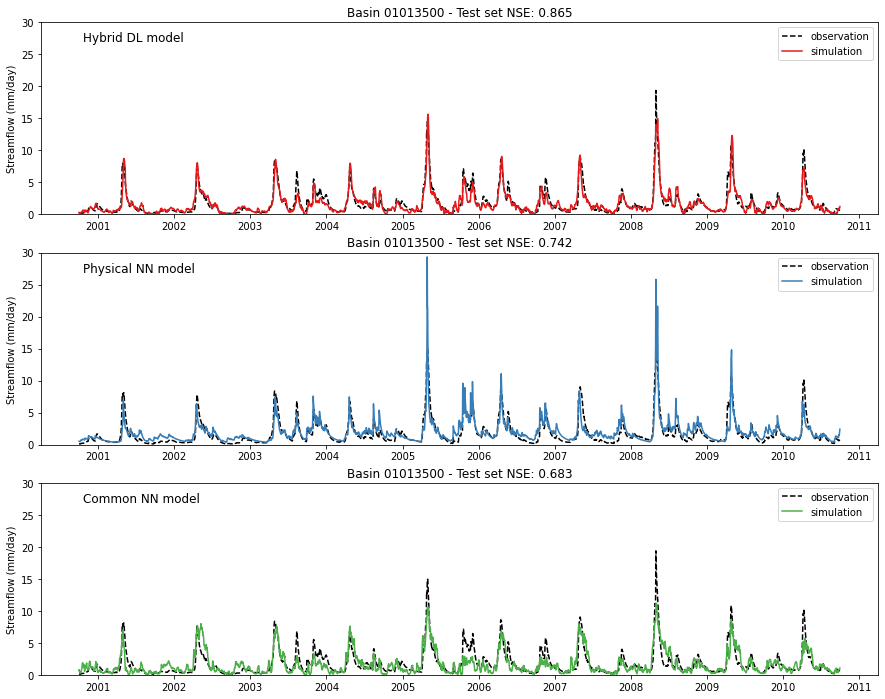

In [14]:
def evaluation_plot(ax, plot_set, plot_name, line_color, nse_values, basin_id):
    ax.plot(plot_set['flow_obs'], label="observation", color='black', ls='--')
    ax.plot(plot_set[plot_name], label="simulation", color=line_color, lw=1.5)
    ax.set_ylim([0, 30])
    ax.set_title(f"Basin {basin_id} - Test set NSE: {nse_values:.3f}")
    ax.set_ylabel("Streamflow (mm/day)")
    ax.legend()

plot_set = evaluate_set[evaluate_set.index.isin(pd.date_range(testing_start, testing_end))]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex='row', figsize=(15, 12))

evaluation_plot(ax1, plot_set, 'flow_hybrid', '#e41a1c', nse_hybrid, basin_id)
evaluation_plot(ax2, plot_set, 'flow_physical', '#377eb8', nse_physical, basin_id)
evaluation_plot(ax3, plot_set, 'flow_common', '#4daf4a', nse_common, basin_id)

ax1.annotate('Hybrid DL model', xy=(0.05, 0.9), xycoords='axes fraction', size=12)
ax2.annotate('Physical NN model', xy=(0.05, 0.9), xycoords='axes fraction', size=12)
ax3.annotate('Common NN model', xy=(0.05, 0.9), xycoords='axes fraction', size=12)

plt.show()